# Session 4: OOI Regional Cabled Array DAS and Non-seismic Applications of Offshore DAS

**Author:** Ethan F. Williams (ethan.williams@ucsc.edu)

The Ocean Observatories Initiative (OOI) is an NSF facility operated by the University of Washington which includes the Regional Cabled Array (RCA), a pair of telemetered seafloor observatories: one site at Hydrate Ridge on the southern Oregon shelf (south cable) and one site at Axial Seamount on the Juan de Fuca Ridge (north cable). 

Each cable of the RCA contains a single fiber pair, and conventional DAS has operated only on dark (unused) fiber. In November 2021, four days of DAS data were acquired on both cables taking advantage of a planned maintenance shutdown. Data can be downloaded <a href="https://doi.org/10.58046/5J60-FJ89">here</a> and results are discussed by <a href="https://doi.org/10.1121/10.0017104">Wilcock et al. (2023)</a>. 

Multiplexing offers a solution for continuous DAS recording on the OOI RCA, permitting recording on lit fiber by mixing C-band telecom signals and L-band DAS signals. In May 2024, four days of DAS data were acquired on the south fiber using an ASN OptoDAS interrogator. Data can be downloaded <a href="https://doi.org/10.58046/4WEF-A282">here</a> and results are discussed by <a href="https://doi.org/10.1785/0220240460">Shi et al. (2025)</a>. Importantly, we found that there was no measurable impact of telecom traffic on DAS data, and no packets were dropped during DAS acquisition. 

In this module, we will examine the 2024 OOI RCA DAS dataset, with particular attention to low-frequency signals associated with ocean waves. We will discuss the scaling of these signals, how to visualize and/or remove them, and potential applications to subduction zone science.

![ooi_2024_map.jpeg](./ooi_2024_map.jpeg)

(Map courtesy of William Wilcock)

In [2]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import h5py
import os
from scipy.signal import butter, filtfilt, freqz, welch
from scipy.signal.windows import tukey

In [3]:
# File paths
fdir = "../../data/ethan"
flist = ["20240508_140005.h5", "20240508_200005.h5"]

### Ocean "noise" on seafloor DAS

Ocean surface gravity waves exist at all scales in the ocean, from capillary-gravity waves at sub-centimeter wavelength to the global tides. The largest waves are in the sea-swell band (~2-20 s period) representing locally generated wind waves and remotely generated swell from storms. Regardless of scale, all ocean surface waves share several fundamental characteristics, which are helpful to understanding their signature in DAS data:

1. The (linear, small-amplitude) dispersion relation is a function of water depth, with slow propagation on the order of meters per second in shallow water near the coast and fast propagation on the order to 10-100 m/s in deep water. Neglecting capillarity, which is only important at very short wavelengths, this relation is 
$$\omega^2 = gk\tanh{kh}.$$ When the wavelength is significantly shorter than the water depth ($kh\gg1$, the deep-water limit), $\tanh{kh}\approx kh$, so 
$$c \approx \sqrt{gh}.$$ When the wavelength is significantly longer than the water depth ($kh\ll1$, the shallow-water limit), $\tanh{kh}\approx 1$, so 
$$c\approx \sqrt{\frac{g}{k}}.$$


2. Pressure decays quasi-exponentially with water depth. For a wave of height $A$, dynamic pressure scales within the water column as 
$$p(z) = \rho g A \frac{\cosh\left[k(z+h)\right]}{\cosh(kh)}.$$ Considering that DAS is typically deployed at the seafloor (z=-h), 
$$p(-h) = \rho g A\frac{1}{\cosh(kh)}.$$ In the deep-water limit, $\cosh(kh)\approx e^{-kh}\rightarrow 0$ and the pressure vanishes. In the shallow-water limit, $\cosh(kh)\approx 1$ and the pressure is depth-invariant. 


3. Combining these two attributes, we can describe the frequency range of the surface gravity wave spectrum that has finite seafloor pressure for a given water depth. Following <a href="https://doi.org/10.1029/91JB01577">Crawford et al. (1991)</a>, if the transition to exponential decay occurs around where the wavelength is similar to the water depth, say $kh\approx 2\pi$, then the maximum observable frequency should scale as
$$\omega_{max} \approx \sqrt{2\pi\frac{g}{h}}.$$

We will now look at an hour of OOI RCA DAS data, and compare expectations (2) and (3) with DAS spectra. To limit the data volume for this workshop, we will work from a decimated file with 20 Hz temporal sampling rate, only covering the 10 km closest to shore. 

In [4]:
# Metadata (see other notebooks for how to extract this from original files)

gl = 40.85200763098726  # Gauge length (m)
dx = 10.213001907746815 # Channel spacing (m)
fs = 20                 # Decimated sampling rate (Hz)
n = 1.4677              # Refractive index
la = 1550e-9            # Wavelength (m)
cfac = la/(4*np.pi*n)   # Amplitude conversion factor (strain per rad)

In [5]:
# Read decimated data for one hour

with h5py.File(os.path.join(fdir,flist[0]),'r') as fp:
    d = fp['data'][:]
ns = d.shape[0]
nx = d.shape[1]

# Convert to strain units
d *= cfac
    
# Compute spectrum with Welch's method
nns = fs * 60 * 10 # window length
nov = nns//2       # window overlap
f, s = welch(d,fs=fs,nperseg=nns,noverlap=nov,scaling='density',axis=0)

(0.001, 10)

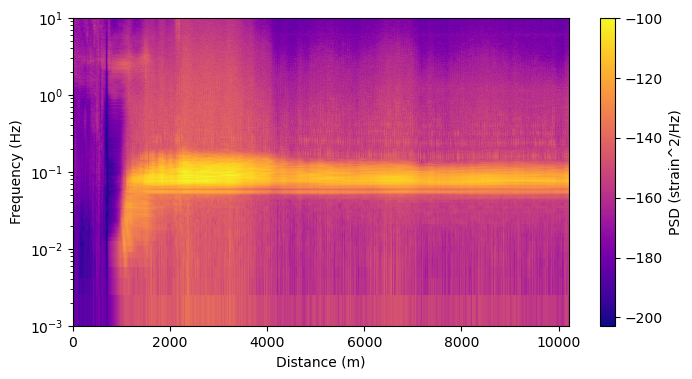

In [6]:
# Plot spectrum for each channel

x = np.arange(nx)*dx # Distance at each channel

plt.figure(figsize=(8,4))
plt.pcolormesh(x,f,10*np.log10(s),cmap='plasma')
plt.xlabel('Distance (m)')
plt.ylabel('Frequency (Hz)')
plt.colorbar(label='PSD (strain^2/Hz)')
plt.gca().set_yscale('log')
plt.ylim([0.001,10])

In [7]:
# Load channel locations and water depth

tmp = np.genfromtxt("depth.txt")
c = tmp[:,0] # channel number
z = tmp[:,1] # water depth
h = -z[:-1]
h[h<=0] = np.nan   # remove shore

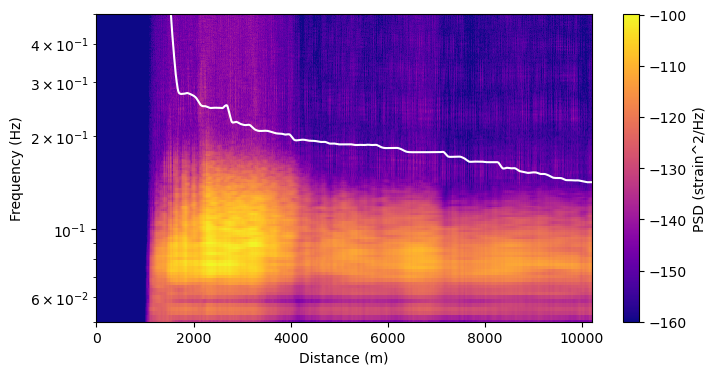

In [8]:
# Compare frequency scaling with linear wave theory

fmax = np.sqrt(2*np.pi*9.8/h)/(2*np.pi)

plt.figure(figsize=(8,4))
plt.pcolormesh(x,f,10*np.log10(s),cmap='plasma',vmin=-160)
plt.plot(x,fmax,'w')
plt.xlabel('Distance (m)')
plt.ylabel('Frequency (Hz)')
plt.colorbar(label='PSD (strain^2/Hz)')
plt.ylim([0.05,0.5])
plt.gca().set_yscale('log')

To compare the pressure amplitude scaling with linear wave theory directly, we need to consider two additional physical factors: wave shoaling and DAS gauge length response:

1. Because the ocean wave speed is slower in shallow water, conservation of energy flux implies an increase in wave height during shoaling. This is an identical phenomenon to shear-wave site amplification, common in seismology. The relative amplitude increase as a function of water depth is given by Green's law,
$$ A(x) = A(x_0) \left(\frac{h(x_0)}{h(x)} \right)^{1/4}.$$


2. DAS measures the average strain over a gauge length, here 40.8 m. We will assume that shoaling ocean waves propagate along the cable and that their strain is vertically polarized such that the DAS directional response can be neglected (see <a href="https://doi.org/10.1002/9781119521808.ch9">Martin et al., 2021</a> for other cases). For a plane progressive wave of the form
$$ \varepsilon = e^{i(kx-\omega t)},$$
the gauge length ($L$) response is then
$$ \varepsilon_{DAS} = \frac{1}{L} \int_{-L/2}^{L/2} e^{i(kx-\omega t)} dx = \frac{1}{L} \left[-\frac{i}{k} e^{i(kx-\omega t)} \right]_{-L/2}^{L/2} = \frac{2\sin(kL/2)}{kL}.$$
This operator is unimportant for $kL\ll1$ (wavelength longer than gauge length), which is almost always true in seismology. However, for ocean waves it is generally important near shore where the wavelength may be only a few meters. 

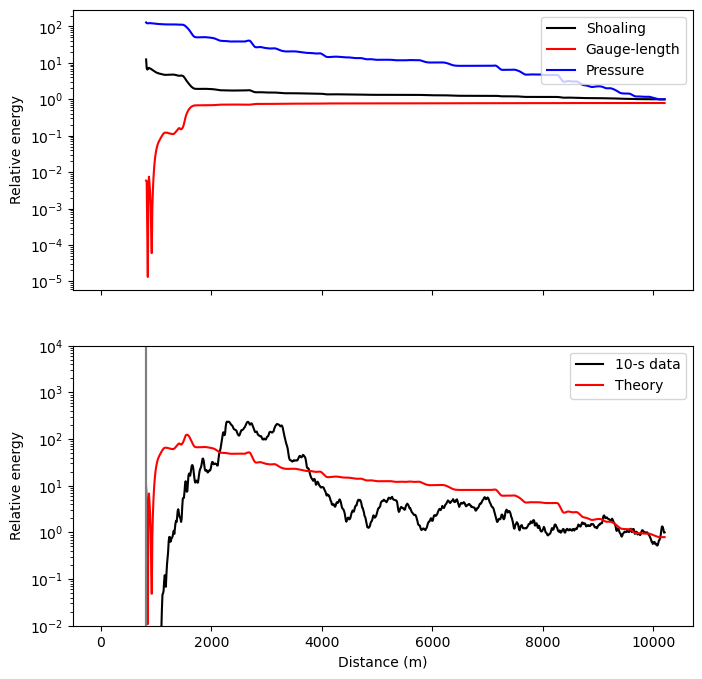

In [9]:
# Compare amplitude scaling with linear wave theory

f0 = 0.1 # 10 s period
ifr = np.argmin(abs(f-f0))

# wavenumber from dispersion at each depth
ks = np.zeros(len(h))
for i in range(len(h)):
    k_ = np.logspace(-5,1,500)
    w_ = np.sqrt(9.8*k_*np.tanh(k_*h[i]))
    ks[i] = np.interp(2*np.pi*f0,w_,k_)

# Depth-dependent pressure transfer function
Hpr = 1./np.cosh(ks*h)
Hpr /= Hpr[-1] # relative to last channel

# Green's law for wave shoaling
Hgr = (h[-1]/h)**0.25

# Wavelength-dependent gauge-length transfer function
Hgl = np.sin(ks*gl/2)/(ks*gl/2)
    
fig, ax = plt.subplots(2,1,sharex=True,figsize=(8,8))
ax[0].semilogy(x,Hgr**2,'k',label='Shoaling')
ax[0].semilogy(x,Hgl**2,'r',label='Gauge-length')
ax[0].semilogy(x,Hpr**2,'b',label='Pressure')
ax[1].axvline(x[np.argmin(abs(z))],c='gray')
ax[0].set_ylabel('Relative energy')
ax[0].legend(loc='upper right')

ax[1].semilogy(x,s[ifr,:]/s[ifr,-1],'k',label='10-s data')
ax[1].semilogy(x,(Hgr*Hgl*Hpr)**2,'r',label='Theory')
ax[1].axvline(x[np.argmin(abs(z))],c='gray')
ax[1].set_ylim([1e-2,1e4])
ax[1].set_xlabel('Distance (m)')
ax[1].set_ylabel('Relative energy')
ax[1].legend()

<b>Conclusion:</b> Linear wave theory and DAS response combined generally describe the nearshore evolution of ocean wave amplitude in the sea/swell band, recognizing the significant uncertainty in nearshore bathymetry. However, the variability of amplitude is significant (RMS about a factor of 5) and varies smoothly over 100+ m distances suggesting that there are systematic variations in mechanical cable coupling and/or depth of burial. For the OOI RCA, we know that the first 2-3 km were directionally drilled under the beach, so a transition in sensitivity around 4-km distance on the plot above (gray line is putative shoreline) is not surprising. This variabiability highlights the need to take care when interpreting the amplitude information in DAS data. Because ocean waves are well understood and exist within a relatively narrow amplitude range (the significant wave height is rarely less than 1 m or more than 10 m), they provide a good "sanity check" for DAS amplitude and coupling variability.

### Space-time and frequency-wavenumber visualization

Now we will focus on the nearshore region and exploit the spatio-temporal resolution of DAS data to look at the shoaling behavior of infragravity waves. Infragravity waves derive their energy from nonlinear interactions with shorter ocean surface waves and are typically generated at or near the coast. The details are unimportant to this exercise, but generally, the infragravity wave energy observed with DAS all across the shelf is controlled by the coastal processes we can see in high resolution across the beach with the same cable. 

While array-based processing of seismic data is now commonplace, seismic arrays rarely have uniform geographic spacing. With DAS, we always have uniform spacing, at least along quasi-linear cable segments, which opens up a broad set of tools from image processing. In particular, we can use a 2D FFT (one FFT along the time axis and one FFT along the channel axis) to obtain a frequency-wavenumber (f-k or FK) spectrum. Much as the frequency spectrum is a sine-wave decomposition of a time-series, the f-k spectrum is a plane wave decomposition of a space-time image. Each point in (f,k) space has a unique phase velocity $c=f/k$, hence different regions of the spectrum correspond to waves propagating at different speeds and/or in different directions. We can either measure these properties directly from the f-k spectrum (in the same manner as beamforming), or we can apply various filtering strategies to separate the wavefield before inverting the 2D FFT. This is one of the most straightforward (and 100% physics-based) ways to remove ocean wave "noise" from earthquake records (or earthquake "noise" from ocean wave records). For more information about this idea, see <a href="https://doi.org/10.1093/gji/ggab407">Atterholt et al. (2023)</a>.

In [10]:
# Load both data files, cut out the nearest channels
xmax = 500 # first 5000 m
tmax = 12000 # first 10 minutes
with h5py.File(os.path.join(fdir,flist[0]),'r') as fp:
    d1 = fp['data'][:,:xmax][:tmax,:]
with h5py.File(os.path.join(fdir,flist[1]),'r') as fp:
    d2 = fp['data'][:,:xmax][:tmax,:]
ns = d1.shape[0]
nx = d1.shape[1]

# Convert to strain units
d1 *= cfac
d2 *= cfac

# Low-pass filter to infragravity band
b,a = butter(4,1./20,fs=fs,btype='lowpass')
df1 = filtfilt(b,a,d1,axis=0)
df2 = filtfilt(b,a,d2,axis=0)

Text(0.5, 1.0, 'High tide')

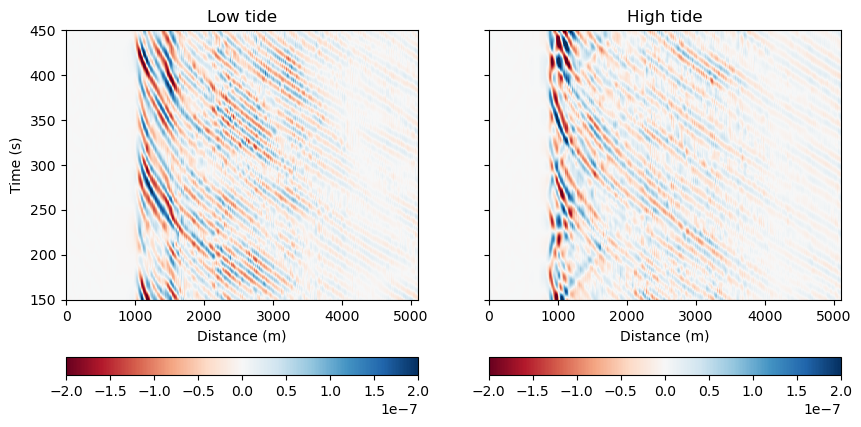

In [11]:
# Plot
x = np.arange(nx)*dx
t = np.arange(ns)/fs
ind = np.logical_and(t>=150,t<=450)

fig, ax = plt.subplots(1,2,sharex=True,sharey=True,figsize=(10,5))
v = 2e-7
im0 = ax[0].pcolormesh(x,t[ind],df1[ind,:],cmap='RdBu',vmin=-v,vmax=v)
im1 = ax[1].pcolormesh(x,t[ind],df2[ind,:],cmap='RdBu',vmin=-v,vmax=v)
plt.colorbar(im0,ax=ax[0],orientation='horizontal')
plt.colorbar(im1,ax=ax[1],orientation='horizontal')
ax[0].set_ylabel('Time (s)')
ax[0].set_xlabel('Distance (m)')
ax[1].set_xlabel('Distance (m)')
ax[0].set_title('Low tide')
ax[1].set_title('High tide')

In [12]:
# 2D taper
tap = np.tile(tukey(ns,0.1),(nx,1)).T * np.tile(tukey(nx,0.1),(ns,1))
d1 *= tap
d2 *= tap

# Frequency-wavenumber spectrum
k = np.fft.fftshift(np.fft.fftfreq(nx,d=dx))
f = np.fft.fftshift(np.fft.fftfreq(ns,d=1./fs))
fk1 = np.fft.fftshift(np.fft.fft2(d1))
fk2 = np.fft.fftshift(np.fft.fft2(d2))

Text(0.5, 1.0, 'High tide')

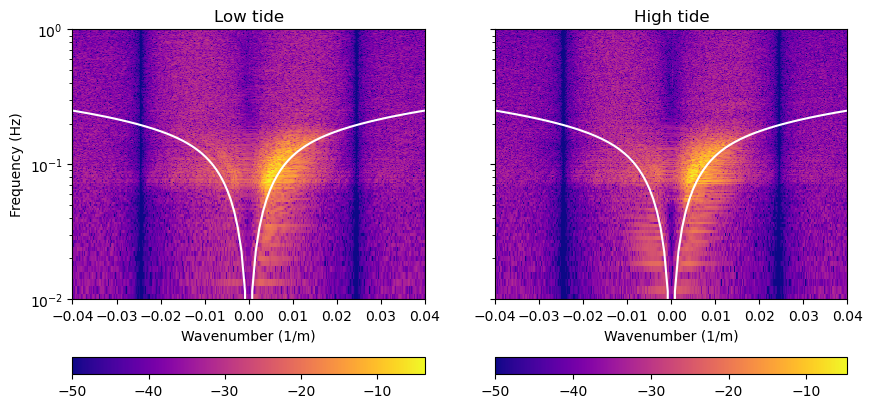

In [13]:
# Plot FK spectrum and compare with dispersion relation

k_ = np.linspace(0,0.04)
f_ = np.sqrt(9.8*2*np.pi*k_*np.tanh(2*np.pi*k_*20))/(2*np.pi)

fig,ax = plt.subplots(1,2,sharex=True,sharey=True,figsize=(10,5))
im0 = ax[0].pcolormesh(k,f,10*np.log10(abs(fk1)),cmap='plasma',vmin=-50)
ax[0].plot(k_,f_,'w')
ax[0].plot(-k_,f_,'w')
im1 = ax[1].pcolormesh(k,f,10*np.log10(abs(fk2)),cmap='plasma',vmin=-50)
ax[1].plot(k_,f_,'w')
ax[1].plot(-k_,f_,'w')
ax[0].set_ylim([0.01,1])
ax[0].set_xlim([-0.04,0.04])
ax[0].set_yscale('log')
plt.colorbar(im0,ax=ax[0],orientation='horizontal')
plt.colorbar(im1,ax=ax[1],orientation='horizontal')
ax[0].set_ylabel('Frequency (Hz)')
ax[0].set_xlabel('Wavenumber (1/m)')
ax[1].set_xlabel('Wavenumber (1/m)')
ax[0].set_title('Low tide')
ax[1].set_title('High tide')

In [14]:
# Wavefield separatation in the frequency-wavenumber domain
K,F = np.meshgrid(k,f)
C = F/K
mask1 = np.where(C>0)
mask2 = np.where(C<0)

fk1in = fk1.copy(); fk1out = fk1.copy()
fk2in = fk2.copy(); fk2out = fk2.copy()

fk1in[mask2] = 0
fk2in[mask2] = 0
fk1out[mask1] = 0
fk2out[mask1] = 0

# Inverse transform
d1in = np.real(np.fft.ifft2(np.fft.fftshift(fk1in)))
d1out = np.real(np.fft.ifft2(np.fft.fftshift(fk1out)))
d2in = np.real(np.fft.ifft2(np.fft.fftshift(fk2in)))
d2out = np.real(np.fft.ifft2(np.fft.fftshift(fk2out)))

# Filter again (normally not necessary, but we plotted the unfiltered FK spectrum for illustration)
b,a = butter(4,1./20,fs=fs,btype='lowpass')
d1in = filtfilt(b,a,d1in,axis=0)
d1out = filtfilt(b,a,d1out,axis=0)
d2in = filtfilt(b,a,d2in,axis=0)
d2out = filtfilt(b,a,d2out,axis=0)

/tmp/ipykernel_27211/250394552.py:3: RuntimeWarning: divide by zero encountered in divide
  C = F/K
/tmp/ipykernel_27211/250394552.py:3: RuntimeWarning: invalid value encountered in divide
  C = F/K


Text(0.5, 1.0, 'High tide - Reflected')

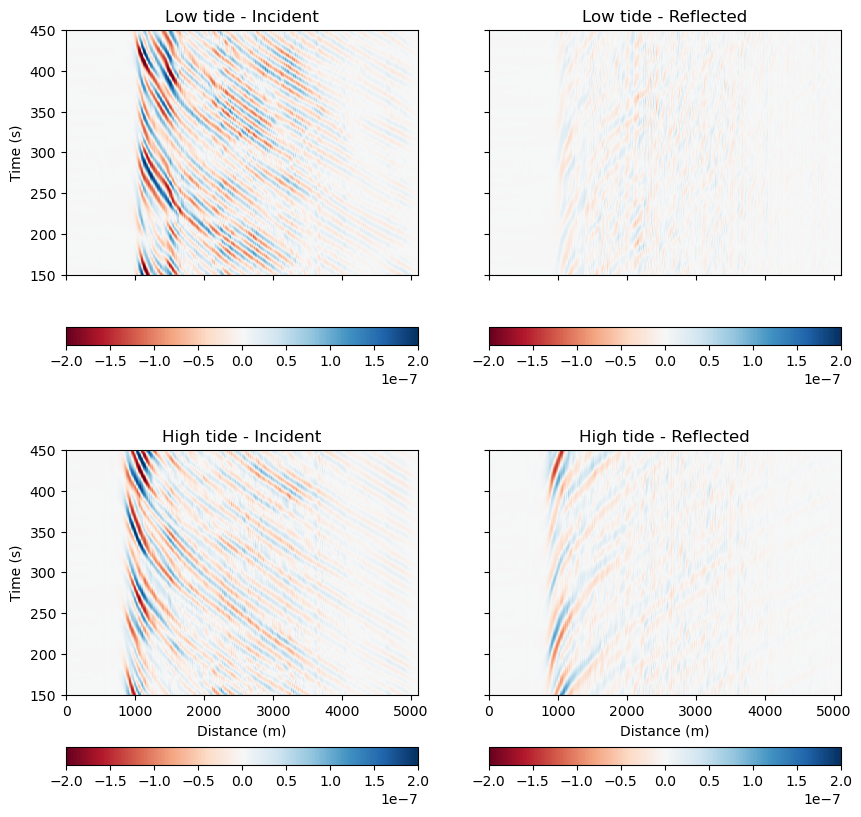

In [15]:
# Separated time-domain wavefield

fig, ax = plt.subplots(2,2,sharex=True,sharey=True,figsize=(10,10))
v = 2e-7
im00 = ax[0,0].pcolormesh(x,t[ind],d1in[ind,:],cmap='RdBu',vmin=-v,vmax=v)
im01 = ax[0,1].pcolormesh(x,t[ind],d1out[ind,:],cmap='RdBu',vmin=-v,vmax=v)
im10 = ax[1,0].pcolormesh(x,t[ind],d2in[ind,:],cmap='RdBu',vmin=-v,vmax=v)
im11 = ax[1,1].pcolormesh(x,t[ind],d2out[ind,:],cmap='RdBu',vmin=-v,vmax=v)
plt.colorbar(im00,ax=ax[0,0],orientation='horizontal')
plt.colorbar(im01,ax=ax[0,1],orientation='horizontal')
plt.colorbar(im10,ax=ax[1,0],orientation='horizontal')
plt.colorbar(im11,ax=ax[1,1],orientation='horizontal')
ax[0,0].set_ylabel('Time (s)')
ax[1,0].set_ylabel('Time (s)')
ax[1,0].set_xlabel('Distance (m)')
ax[1,1].set_xlabel('Distance (m)')
ax[0,0].set_title('Low tide - Incident')
ax[0,1].set_title('Low tide - Reflected')
ax[1,0].set_title('High tide - Incident')
ax[1,1].set_title('High tide - Reflected')

<b>Conclusions:</b>

1. The interference pattern that we see near shore at high tide comes from incident and reflected waves of subequal amplitude. An alternative hypothesis that has been suggested with past conventional nearshore pressure records (lacking spatial resolution) is that this interference pattern is the cross-shore mode structure of edge waves, a type of cross-shore standing, long-shore propagating mode analagous to seismic surface waves. We didn't provide high-resolution nearshore bathymetry in this notebook, but the variation in reflection coefficient from low tide (<0.1) to high tide (~1) comes from the concave beach profile: it is steep and reflective at high tide, but gently-sloping and dissipative at low tide. If you want to hear more, <a href="https://agu.confex.com/agu/agu25/meetingapp.cgi/Paper/1926087">come to my talk on Wednesday</a>.


2. It's not particularly clear in the very narrow-aperture f-k spectrum as shown here, but we see that infragravity waves follow the same dispersion relation as shorter swell and wind waves, and that this matches the dispersion relation from linear wave theory. On conventional seismic arrays, we often see "primary microseism," seismic waves generated by ocean-solid Earth interaction that are radiated across the continents. While our amplitude and frequency scaling relationships above indicated that we should expect to see ocean surface gravity waves in this range of water depths, only the f-k spectrum directly proves that this signal is the in-situ loading under ocean waves, not the far-field seismic noise generated by ocean waves.


3. Note that everything so far has been vectorized, which is another advantage of uniformly sampled 2D arrays. 

### Ocean wave interferometry

Cross-correlation provides a particularly clear example of efficient coding practices for DAS data, and also renders a beautiful picture of the nearshore infragravity wave dynamics discussed above. Ideally, step 1 is to decimate the data after filtering, particularly we have 20 Hz sampling rate and will low-pass filter below 20-s to see infragravity waves. Since we will only run this once, resampling the data is actually more time intensive.

In [26]:
xmax = 500 # first 5000 m
with h5py.File(os.path.join(fdir,flist[1]),'r') as fp:
    d = fp['data'][:,:xmax]
ns = d.shape[0]
nx = d.shape[1]
d *= cfac

# Low-pass filter to infragravity band (only needed if doing time-domain whitening first)
b,a = butter(4,1./20,fs=fs,btype='lowpass')
d = filtfilt(b,a,d,axis=0)

In [27]:
nns = 2**13                 # samples per window, here about 400 s
nwn = int(np.floor(ns/nns)) # number of windows in the file
isr = 200                   # source channel
fmin = 1./100               # frequencies for spectral normalization
fmax = 1./25

# Trim data to even number of windows
d = d[:nns*nwn]

# Reshape data to a 3D array (num channels, num windows, num samples)
d = np.reshape(d.T,(nx,nwn,nns))

# Taper each window
d *= np.tile(np.hamming(nns),(nx,nwn,1))

# One bit whitening
d = np.sign(d)

# Calculate FFT
s = np.fft.rfft(d,axis=2)

# Spectral whitening
f = np.fft.rfftfreq(nns,d=1./fs)
i1 = np.argmin(abs(f-fmin))
i2 = np.argmin(abs(f-fmax))
ph = np.exp(1j*np.angle(s))
s[:,:,:i1] = np.tile(np.cos(np.linspace(np.pi/2,np.pi,i1))**2,(nx,nwn,1))
s[:,:,i1:i2] = np.ones(i2-i1)
s[:,:,i2:] = np.tile(np.cos(np.linspace(np.pi,np.pi/2,len(f)-i2))**2,(nx,nwn,1))
s *= ph

# Cross-correlation (multiplication)
src = np.tile(s[isr,:,:],(nx,1,1))
s *=  np.conj(src)

# Stack (linear)
s = np.mean(s,axis=1)

# Calculate IFFT
xc = np.fft.irfft(s,axis=1)

In [28]:
t = np.arange(-nns//2,nns//2)/fs
xc = np.fft.fftshift(xc,axes=1).T # flip XC

b,a = butter(4,1./20,fs=fs,btype='lowpass')
xc = filtfilt(b,a,xc,axis=0)

Text(0, 0.5, 'Time lag(s)')

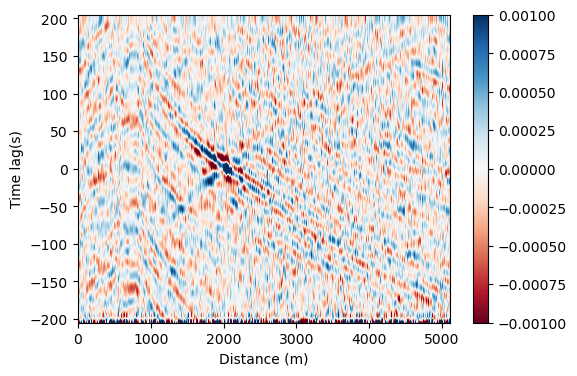

In [29]:
plt.figure(figsize=(6,4))
v = 1e-3
plt.pcolormesh(x,t,xc,cmap='RdBu',vmin=-v,vmax=v)
plt.colorbar()
plt.xlabel('Distance (m)')
plt.ylabel('Time lag(s)')

In [32]:
# Frequency-wavenumber spectrum of the cross-correlation
f = np.fft.fftfreq(nns,d=1./fs)
k = np.fft.fftfreq(nx,d=dx)
xcfk = np.fft.fft2(xc)

f = np.fft.fftshift(f)
k = np.fft.fftshift(k)
xcfk = np.fft.fftshift(xcfk)

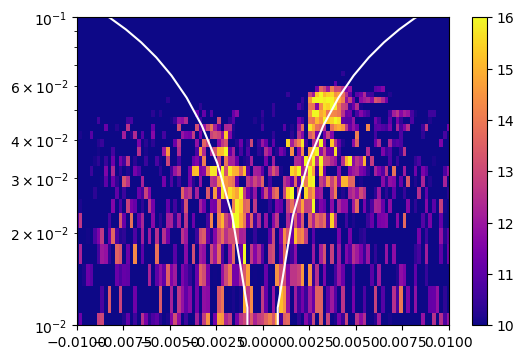

In [36]:
plt.figure(figsize=(6,4))
plt.pcolormesh(k,f,10*np.log10(abs(xcfk)),cmap='plasma',vmin=10,vmax=16)
plt.plot(k_,f_,'w')
plt.plot(-k_,f_,'w')
plt.xlim([-0.01,0.01])
plt.ylim([0.01,0.1])
plt.gca().set_yscale('log')
plt.colorbar()
plt.xlabel('Wavenumber (1/m)')
plt.ylabel('Frequency (Hz)')

### Opportunities in subduction-zone science with ocean waves

We just spent half an hour looking at ocean signals in DAS data. Why should you, a solid-Earth geoscientist at an SZ4D workshop, care about ocean waves?

1. <i>Tsunami detection and early warning:</i> Sensing with DAS on offshore cable networks is a promising solution for detecting and estimating the size of tsunamis in the minutes after a great earthquake. Much as we rely on decades of seismic data to develop and test earthquake early warning (EEW) algorithms before their public implementation (and we still get phantom M5.9 events...), the first step is to characterize the ocean-bottom strain field across time. How do we distinguish true tsunamis from infragravity waves, set-up during storms, rogue waves, or even internal waves, which occupy some of the same space-time scales and obey the same physics?


2. <i>Fiber-optic geodesy:</i> Low-frequency applications of DAS from monitoring <a href="https://doi.org/10.1126/science.adu0225">dike intrusion</a> to <a href="https://doi.org/10.1029/2023JC019980">seafloor temperature</a> have become increasingly common as the noise floor and long-period drift of DAS continues to improve. As many seafloor fiber-optic cables span the trench and forearc wedge, it is natural to look towards DAS as an alternative offshore geodetic technique. Yet, there is no way to easily distinguish strain transients from ocean loading and slow earthquakes on a single-component seafloor strainmeter array without a strong physical understanding of the ocean processes. 


3. <i>Tsunami model validation:</i> One of the greatest challenges in tsunami modeling is the beach boundary, where "wetting" and "drying" of cells is not only difficult to implement but difficult to validate, with a scarcity of shore-crossing observations and necessary parameterization of nonlinear processes like breaking. Most tsunami codes are validated against a few analytical solutions for idealized beach profiles (<a href="https://doi.org/10.1017/S0022112058000331">Carrier and Greenspan, 1958</a>) and a few laboratory tests (e.g. <a href="https://doi.org/10.1017/S002211208700329X">Synolakis, 1987</a>). Above, we have shown phase-resolved images of infragravity run-up, which could form the basis of new model validation exercises with realistic, complex beach bathymetry. In particular, we observed that a tidal excursion of only about 90 m on a strongly concave beach could change the reflection coefficient by a factor of 10; would existing codes reproduce this? 


4. <i>Seafloor compliance and shallow marine sediments:</i> When you have an ocean-bottom DAS array, ambient noise interferometry and Rayleigh/Scholte-wave inversion is the straigtforward way to estimate the velocity structure of shallow marine sediments. Compliance and admittance methods used on conventional OBS require both pressure and ground-motion sensors, and provide poorer depth resolution than Rayleigh/Scholte-wave inversion regardless. However, ocean wave compliance has at least two unique aspects. First, ocean wave loading during strong winter storms is a commonly-cited trigger for turbidity currents, suggesting that the cyclic stress induced by ocean waves can illuminate (nonlinear, poroelastic) sediment rheology across the broad spectrum from small-strain to failure. Second, the spatial evolution of ocean surface waves is well understood (frictional dissipation is low, even on the shelf, and topography tends to be smooth enough that it refracts, not reflects, waves away from the beach), so spatial variations in DAS-measured compliance can be a good indicator of coupling variability. 